In [0]:
import h5py
import numpy as np
import os,random
from keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from keras import layers
import keras.models as Model
from keras.regularizers import *
from keras.optimizers import adam
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

Using TensorFlow backend.


In [0]:
f = h5py.File('drive/RadioModulationRecognition/Data_dir/part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(0,sample_num),size=30000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    if i%2 == 0:
        !free -m
    '''if i == 10:
        continue'''
    filename = 'drive/RadioModulationRecognition/Data_dir/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X维度：',X.shape)
print('Y维度：',Y.shape)
print('Z维度：',Z.shape)


drive/RadioModulationRecognition/Data_dir/part1.h5
              total        used        free      shared  buff/cache   available
Mem:          13022        1585        7955           0        3481       12063
Swap:             0           0           0
drive/RadioModulationRecognition/Data_dir/part2.h5
drive/RadioModulationRecognition/Data_dir/part3.h5
              total        used        free      shared  buff/cache   available
Mem:          13022        2563        5705           0        4753       12213
Swap:             0           0           0
drive/RadioModulationRecognition/Data_dir/part4.h5
drive/RadioModulationRecognition/Data_dir/part5.h5
              total        used        free      shared  buff/cache   available
Mem:          13022        5185        1833           0        6003       10792
Swap:             0           0           0
drive/RadioModulationRecognition/Data_dir/part6.h5
drive/RadioModulationRecognition/Data_dir/part7.h5
              total        used

In [0]:
"""数据预处理，并获取训练集和测试集"""
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)   #80%训练样本
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #随机选取训练样本下标
test_idx = list(set(range(0,n_examples))-set(train_idx)) #测试样本下标
X_train = X[train_idx]  #训练样本
X_test =  X[test_idx]  #测试样本
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (503999, 1024, 2)
Y_train: (503999, 24)
X_test: (216001, 1024, 2)
Y_test: (216001, 24)


In [0]:
"""建立模型"""
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

def residual_stack(X,Filters,Seq,max_pool):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", init='glorot_uniform',data_format="channels_first")(X)
    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", init='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", init='glorot_uniform',data_format="channels_first")(X)
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", init='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", init='glorot_uniform',data_format="channels_first")(X)
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X


in_shp = X_train.shape[1:]   #每个样本的维度
#input layer
X_input = Input(in_shp)
X = Reshape([1,1024,2], input_shape=in_shp)(X_input)
#Residual Srack 1
X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
#Residual Srack 2
X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
#Residual Srack 3
X = residual_stack(X,32,"ReStk3",True)  #shape:(1,128,32)
#Residual Srack 4
X = residual_stack(X,32,"ReStk4",True)  #shape:(1,64,32)
#Residual Srack 5
X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
#Residual Srack 6
X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)
#Full Con 1
X = Flatten()(X)
X = Dense(128, activation='selu', init='he_normal', name="dense1")(X)
X = AlphaDropout(0.3)(X)
#Full Con 2
X = Dense(128, activation='selu', init='he_normal', name="dense2")(X)
X = AlphaDropout(0.3)(X)
#Full Con 3
X = Dense(len(classes), init='he_normal', name="dense3")(X)
#SoftMax
X = Activation('softmax')(X)
#Create Model
model = Model.Model(inputs=X_input,outputs=X)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), padding="same", name="ReStk1_conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 2), padding="same", activation="relu", name="ReStk1_conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 2), padding="same", name="ReStk1_conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 2), padding="same", activation="relu", name="ReStk1_conv4", data_format="channels_first", kern

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 2)      0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 1024, 2)   0           input_1[0][0]                    
__________________________________________________________________________________________________
ReStk1_conv1 (Conv2D)           (None, 32, 1024, 2)  64          reshape_1[0][0]                  
__________________________________________________________________________________________________
ReStk1_conv2 (Conv2D)           (None, 32, 1024, 2)  6176        ReStk1_conv1[0][0]               
__________________________________________________________________________________________________
ReStk1_con

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="selu", name="dense1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="selu", name="dense2", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, name="dense3", kernel_initializer="he_normal")`


In [0]:
"""训练模型"""
# perform training ...
#   - call the main training loop in keras for our network+dataset
print(tf.test.gpu_device_name())
filepath = 'drive/RadioModulationRecognition/Models/ResNet_Model_60w.wts.h5'
model.load_weights(filepath) #加载之前训练了一段时间的模型

history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=2,
    validation_data=(X_test, Y_test),
    #validation_split = 0.2,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

/device:GPU:0
Train on 503999 samples, validate on 216001 samples
Epoch 1/100
 - 491s - loss: 1.2607 - val_loss: 1.4712
Epoch 2/100
 - 488s - loss: 1.2553 - val_loss: 1.3239
Epoch 3/100
 - 488s - loss: 1.2474 - val_loss: 1.2966
Epoch 4/100
 - 488s - loss: 1.2425 - val_loss: 1.3121
Epoch 5/100
 - 488s - loss: 1.2532 - val_loss: 1.2609
Epoch 6/100
 - 488s - loss: 1.2325 - val_loss: 1.2839
Epoch 7/100
 - 488s - loss: 1.2279 - val_loss: 1.2652
Epoch 8/100
 - 488s - loss: 1.2262 - val_loss: 1.2641
Epoch 9/100
 - 488s - loss: 1.2244 - val_loss: 1.3021
Epoch 10/100
 - 488s - loss: 1.2220 - val_loss: 1.3065


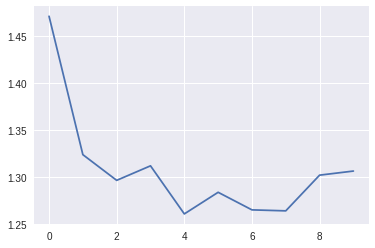

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
loss_list = history.history['val_loss']
plt.plot(range(len(loss_list)),loss_list)
plt.show()

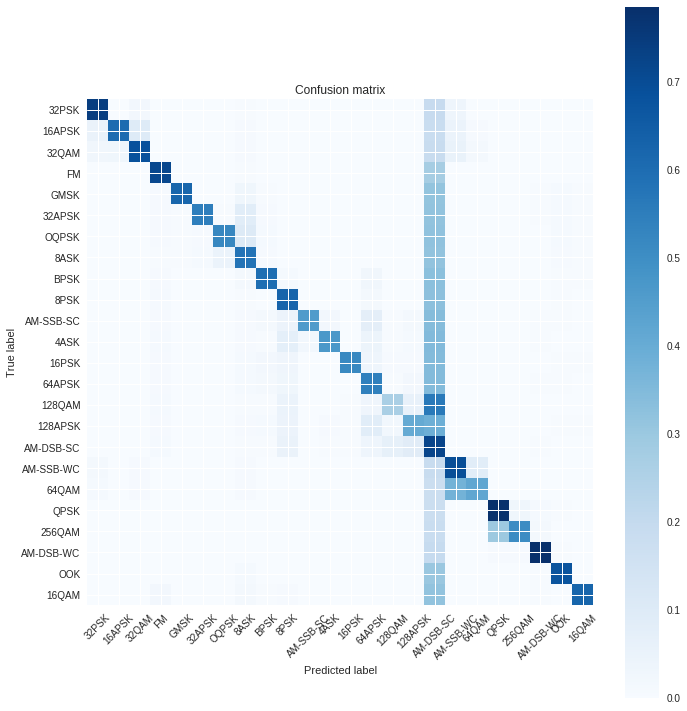

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [0]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.7389800245508313
16APSK 0.6037883008356546
32QAM 0.6843403205918619
FM 0.712004530011325
GMSK 0.6198115324209109
32APSK 0.5461047535211268
OQPSK 0.5235242866477892
8ASK 0.5822306238185255
BPSK 0.594854586129754
8PSK 0.6265752818925492
AM-SSB-SC 0.45365908326795923
4ASK 0.46633972358448506
16PSK 0.5160535117056856
64APSK 0.5419631763244098
128QAM 0.2640817686923675
128APSK 0.40605658709106984
AM-DSB-SC 0.7175285129000111
AM-SSB-WC 0.6949096518289996
64QAM 0.4179037336932074
QPSK 0.7806308799114554
256QAM 0.5073004720605994
AM-DSB-WC 0.7846119684689686
OOK 0.676538844071168
16QAM 0.6239520958083832


Overall Accuracy -20:  0.042955119720851885
Overall Accuracy -18:  0.04193509177099793
Overall Accuracy -16:  0.04264776549735704
Overall Accuracy -14:  0.04828248858995916
Overall Accuracy -12:  0.06513783849719444
Overall Accuracy -10:  0.10644624167459563
Overall Accuracy -8:  0.1656426936513673
Overall Accuracy -6:  0.2294455066921606
Overall Accuracy -4:  0.29657011271361045
Overall Accuracy -2:  0.394954954954955


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Overall Accuracy 0:  0.5218956208758249
Overall Accuracy 2:  0.6216575922565033
Overall Accuracy 4:  0.7202366578121226
Overall Accuracy 6:  0.8195209580838323
Overall Accuracy 8:  0.8840490797546012
Overall Accuracy 10:  0.9160628019323671
Overall Accuracy 12:  0.9270908652687394
Overall Accuracy 14:  0.9262363788767812
Overall Accuracy 16:  0.9321025142718329
Overall Accuracy 18:  0.9358562418183982
Overall Accuracy 20:  0.9341558903784554
Overall Accuracy 22:  0.9377025567158804
Overall Accuracy 24:  0.9336125138563862
Overall Accuracy 26:  0.9355691789878591
Overall Accuracy 28:  0.9362329090051862
Overall Accuracy 30:  0.9354374174966998


<Figure size 432x288 with 0 Axes>

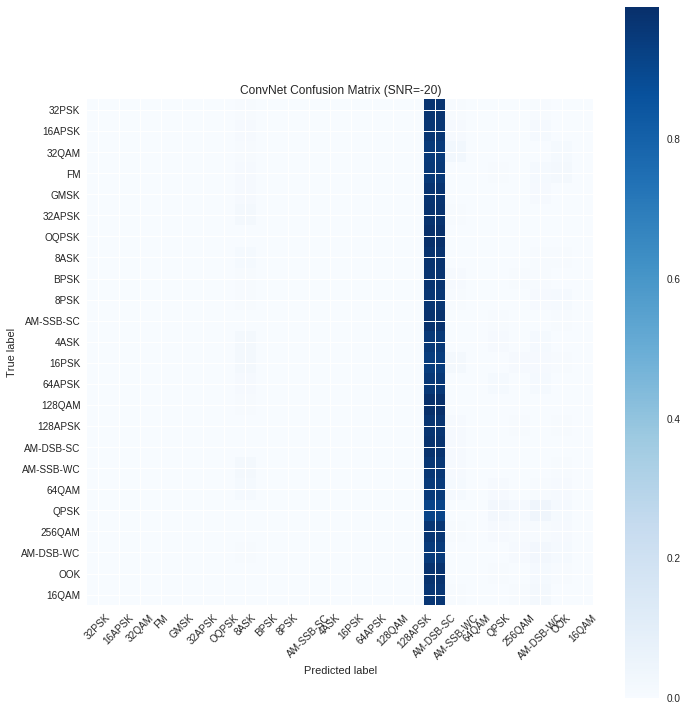

<Figure size 432x288 with 0 Axes>

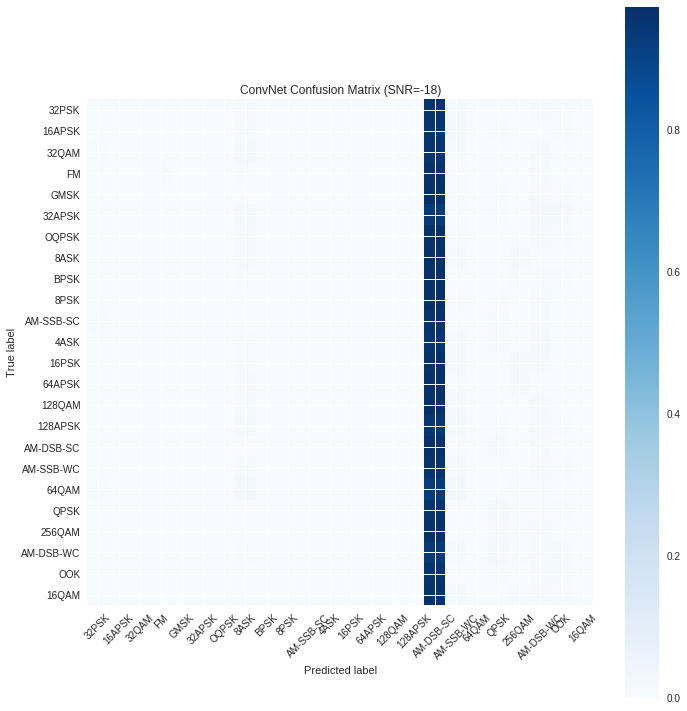

<Figure size 432x288 with 0 Axes>

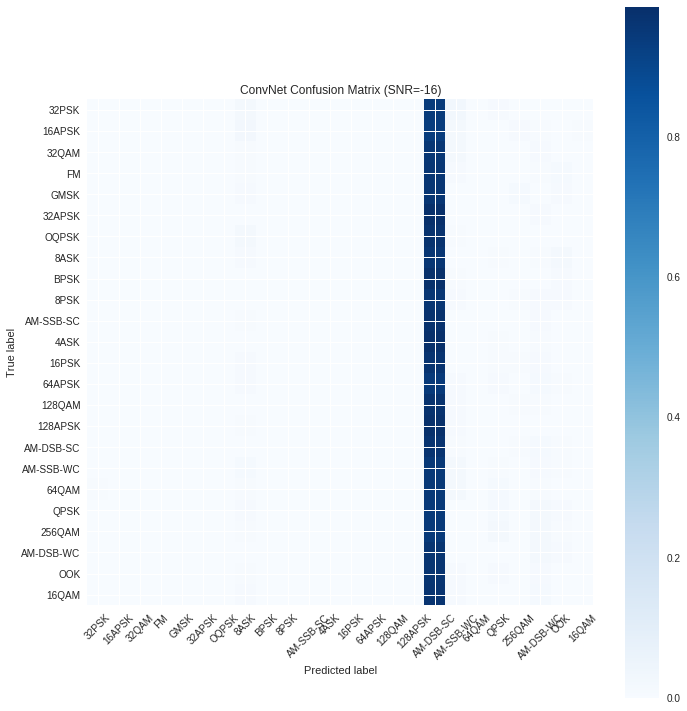

<Figure size 432x288 with 0 Axes>

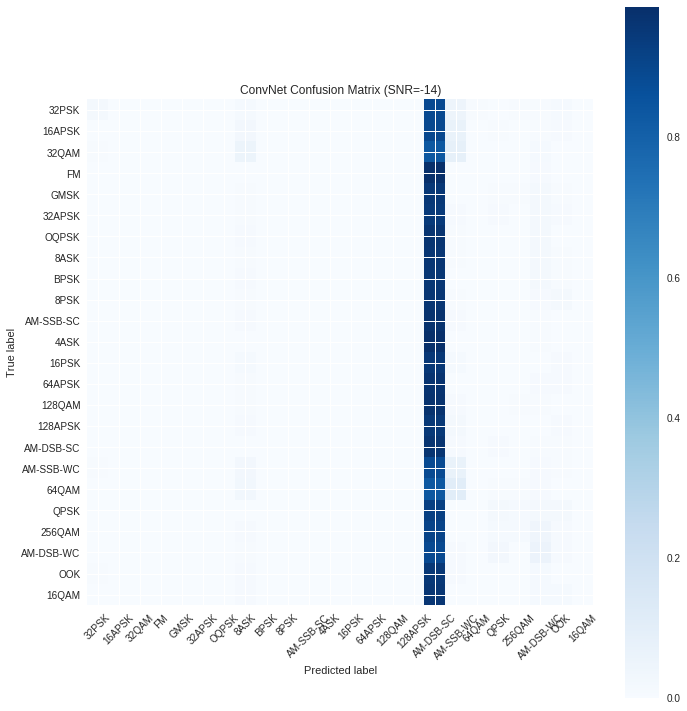

<Figure size 432x288 with 0 Axes>

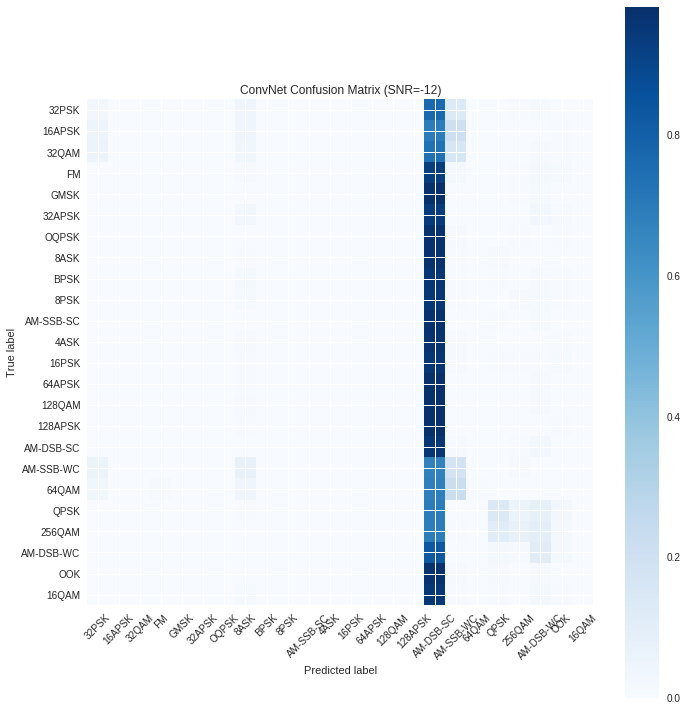

<Figure size 432x288 with 0 Axes>

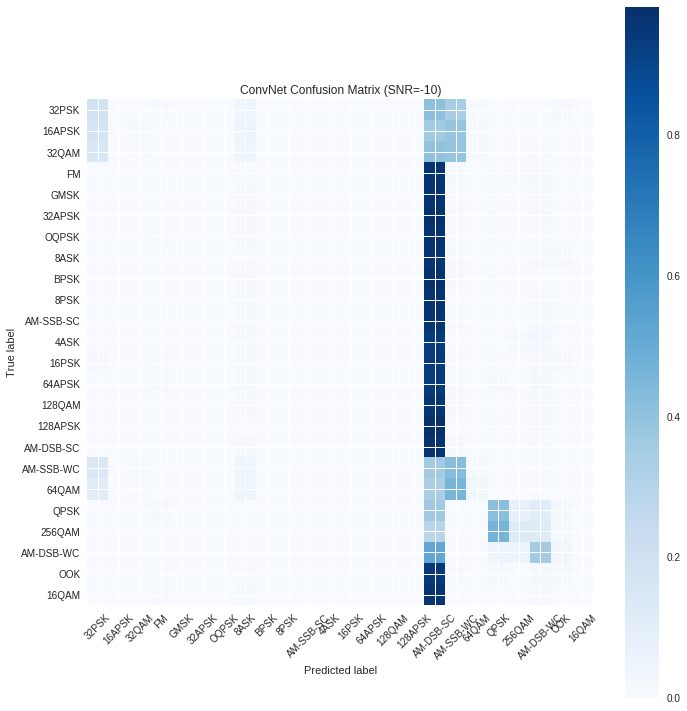

<Figure size 432x288 with 0 Axes>

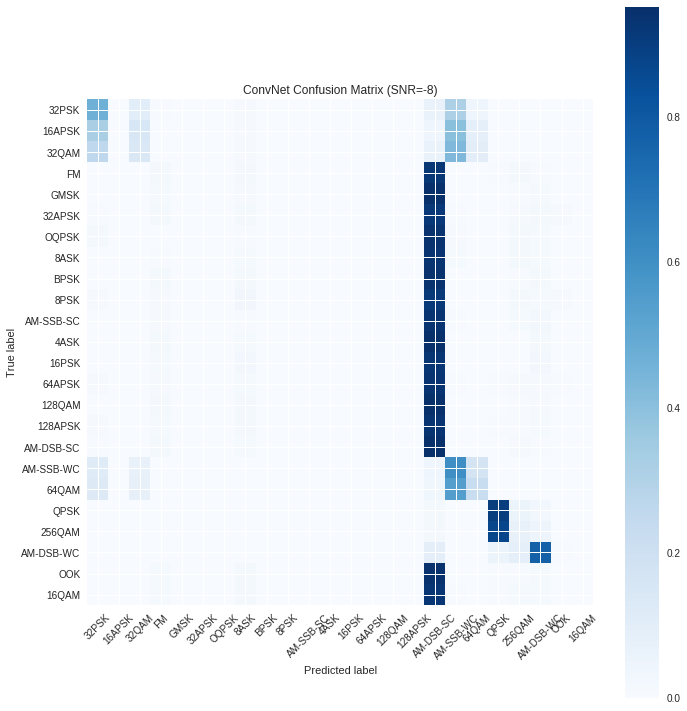

<Figure size 432x288 with 0 Axes>

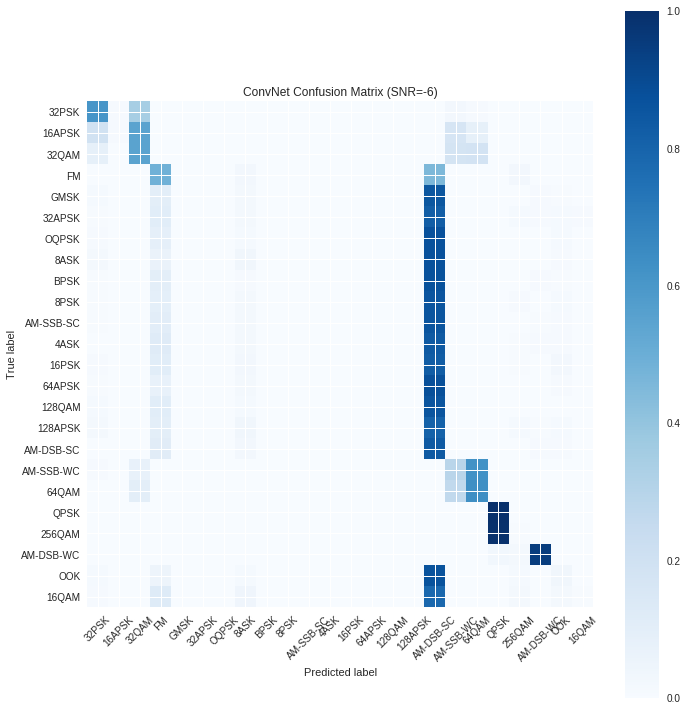

<Figure size 432x288 with 0 Axes>

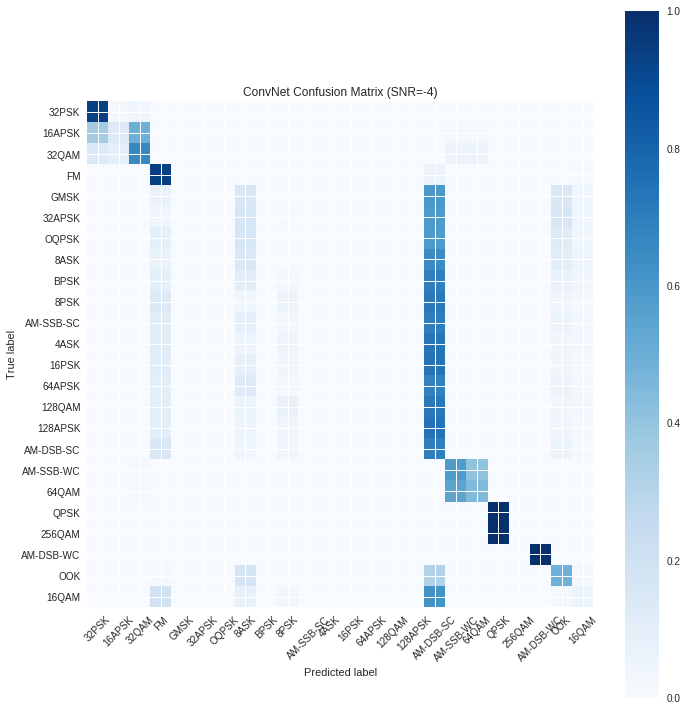

<Figure size 432x288 with 0 Axes>

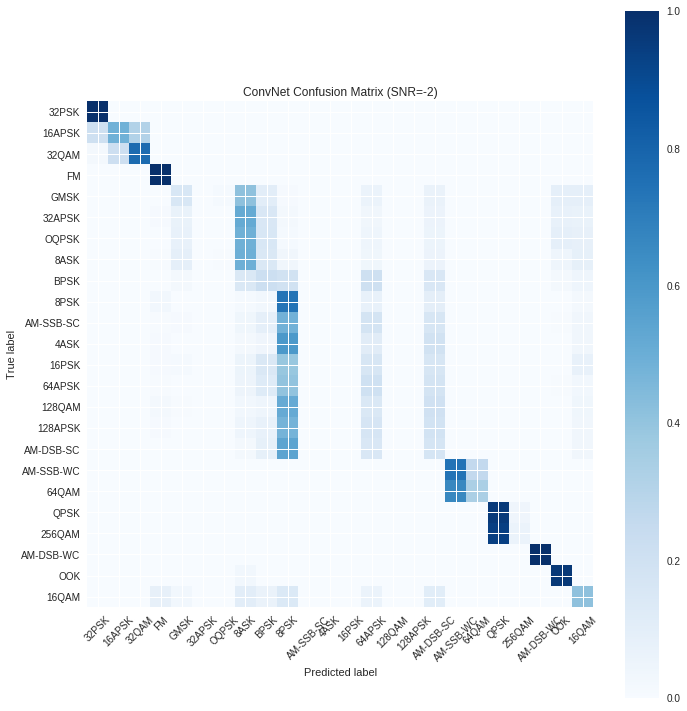

<Figure size 432x288 with 0 Axes>

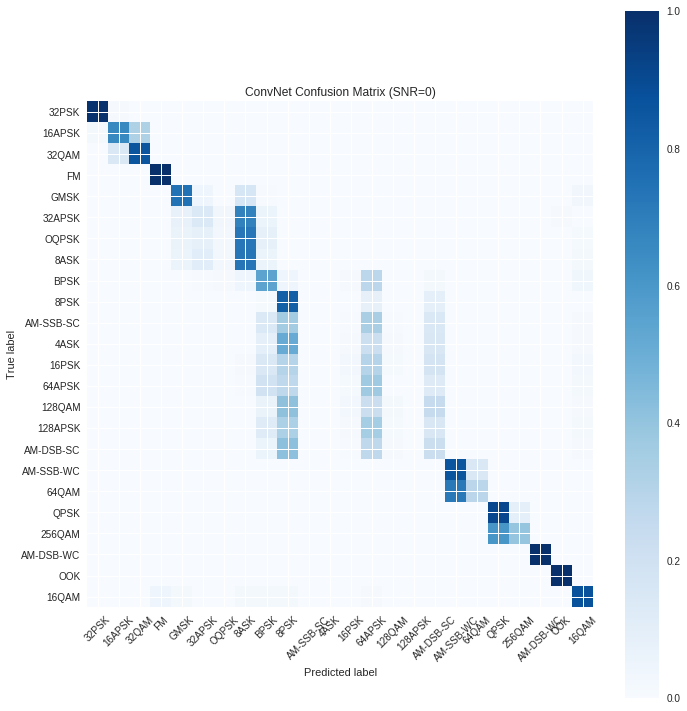

<Figure size 432x288 with 0 Axes>

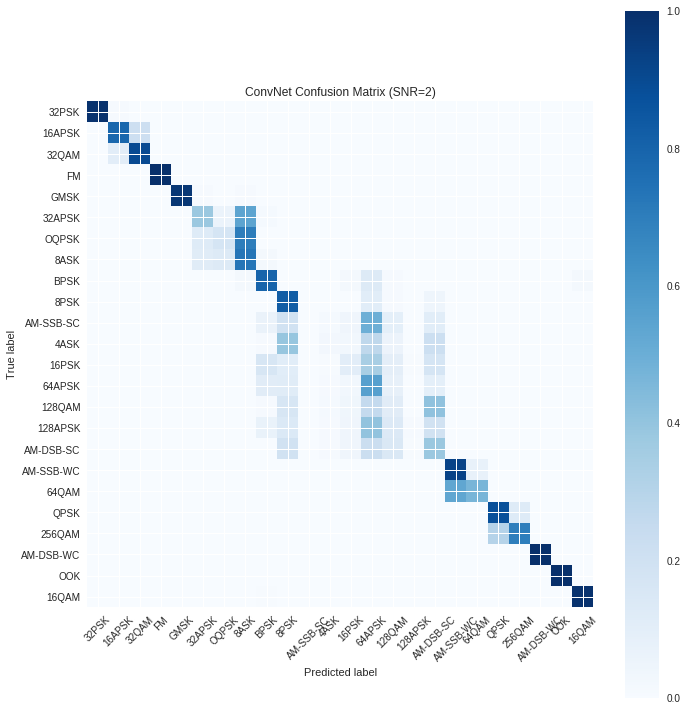

<Figure size 432x288 with 0 Axes>

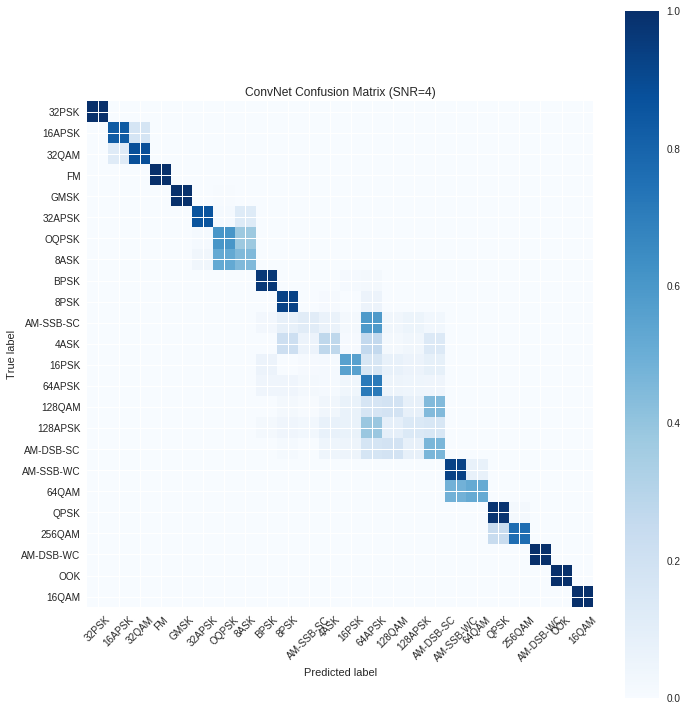

<Figure size 432x288 with 0 Axes>

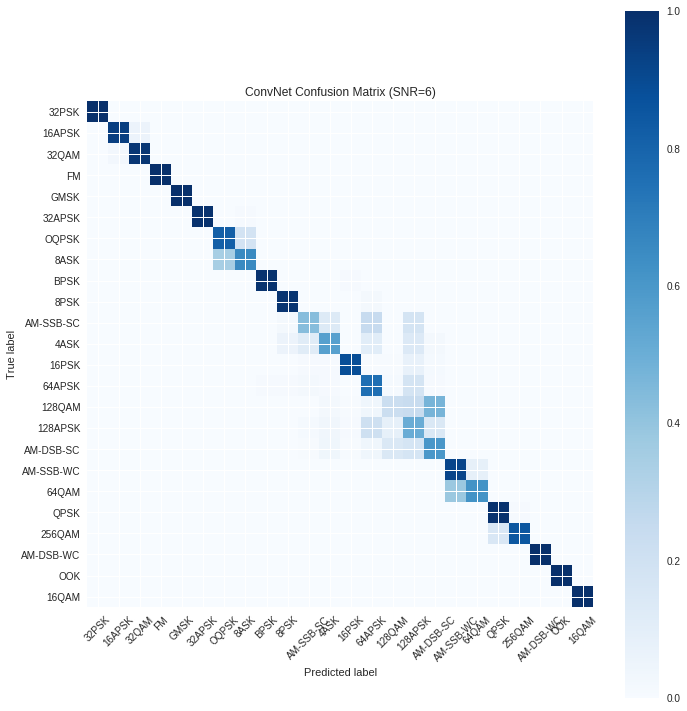

<Figure size 432x288 with 0 Axes>

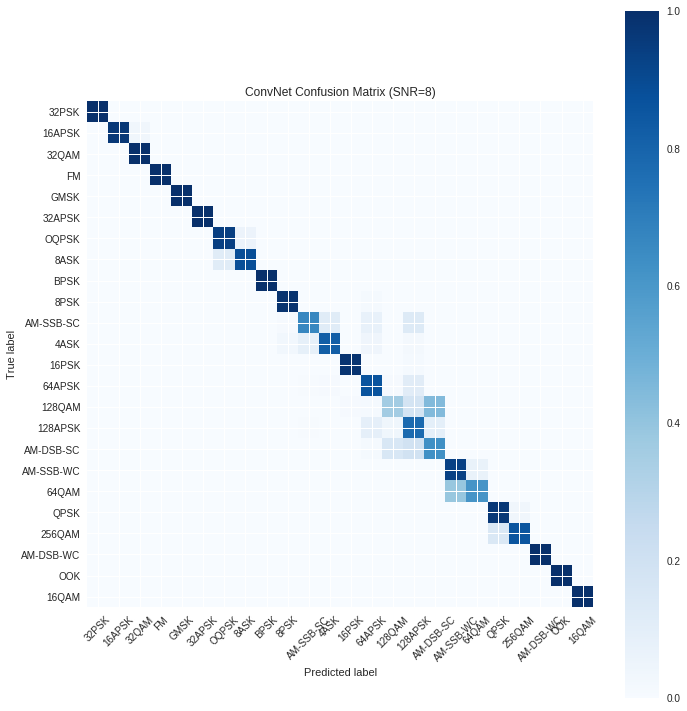

<Figure size 432x288 with 0 Axes>

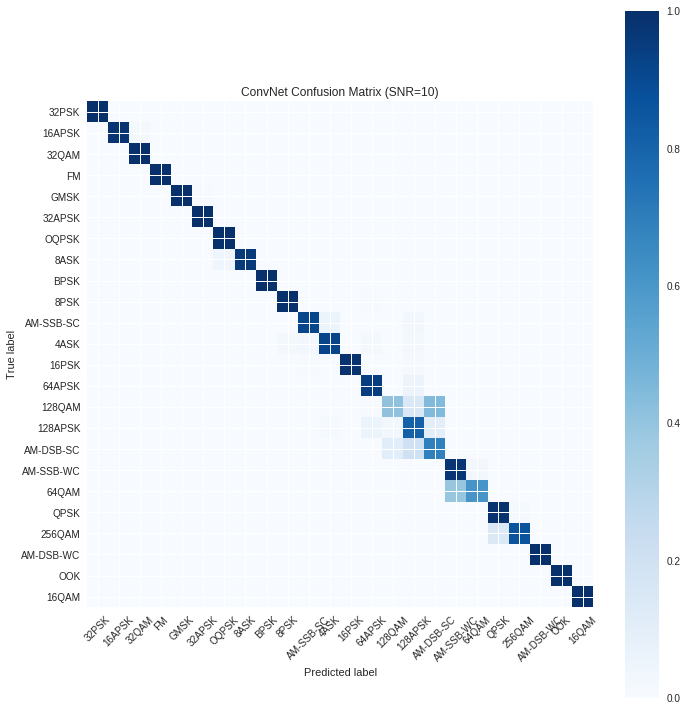

<Figure size 432x288 with 0 Axes>

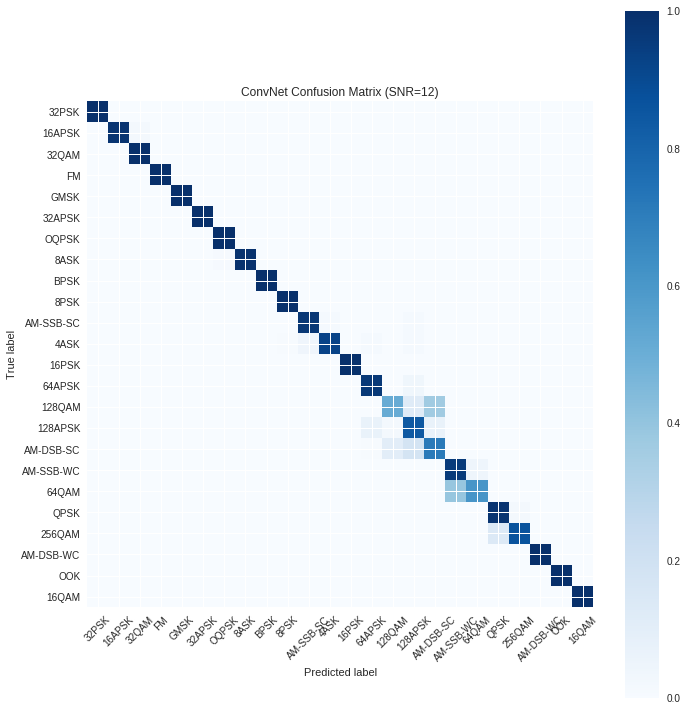

<Figure size 432x288 with 0 Axes>

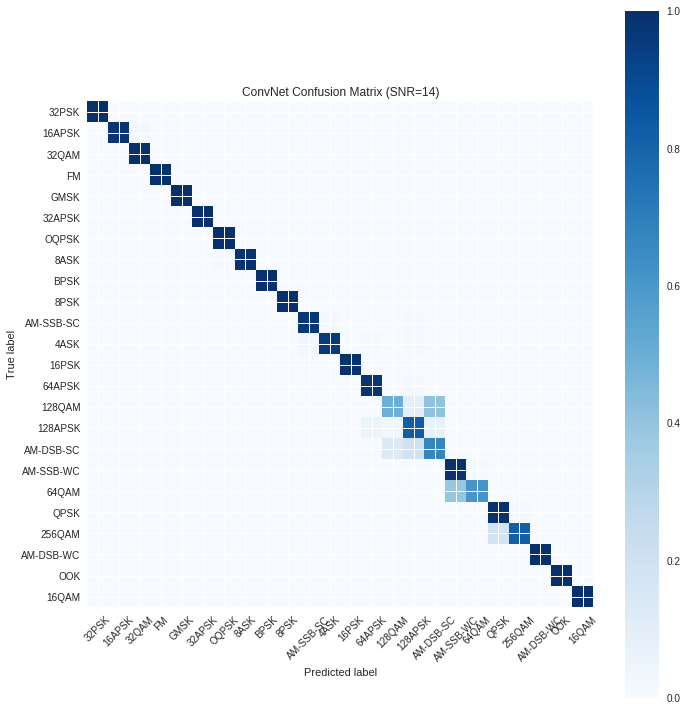

<Figure size 432x288 with 0 Axes>

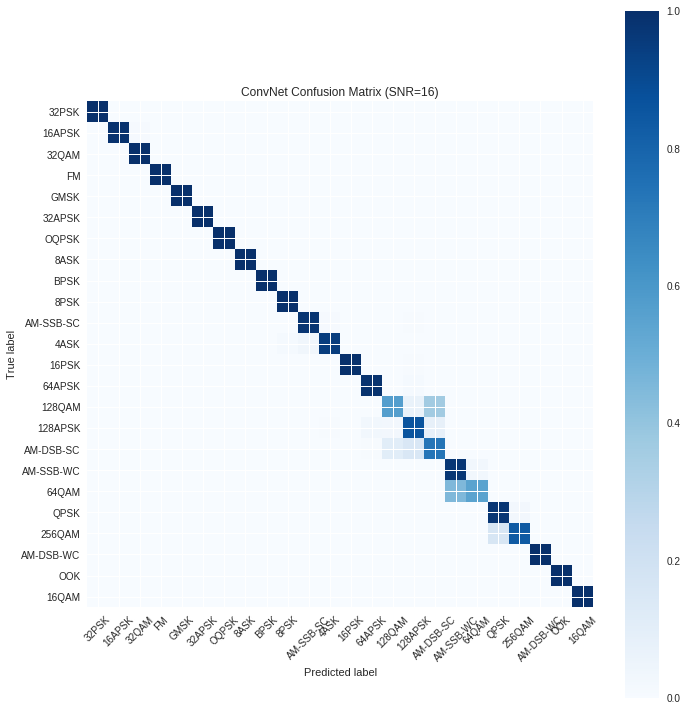

<Figure size 432x288 with 0 Axes>

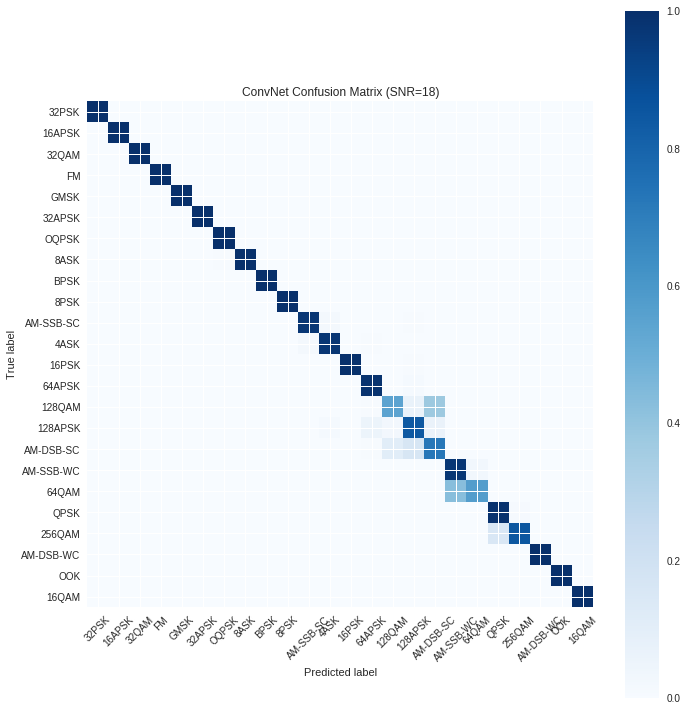

<Figure size 432x288 with 0 Axes>

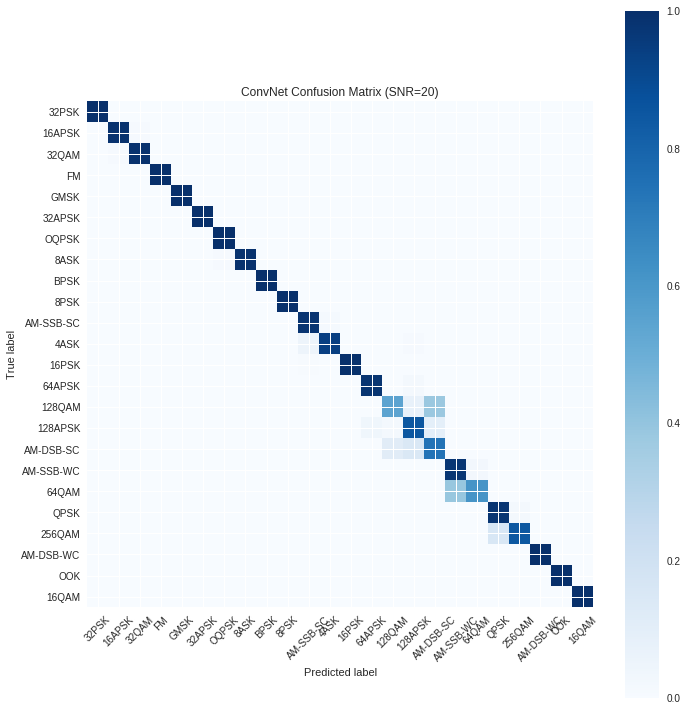

<Figure size 432x288 with 0 Axes>

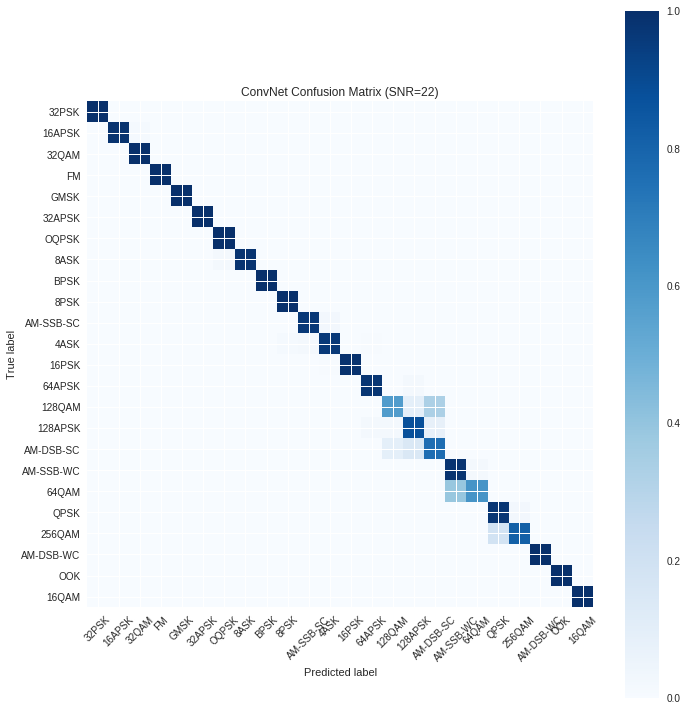

<Figure size 432x288 with 0 Axes>

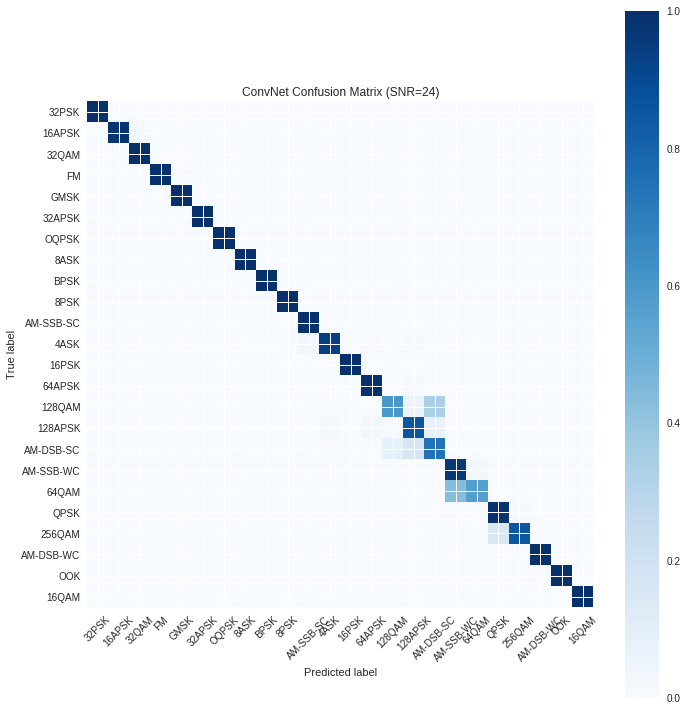

<Figure size 432x288 with 0 Axes>

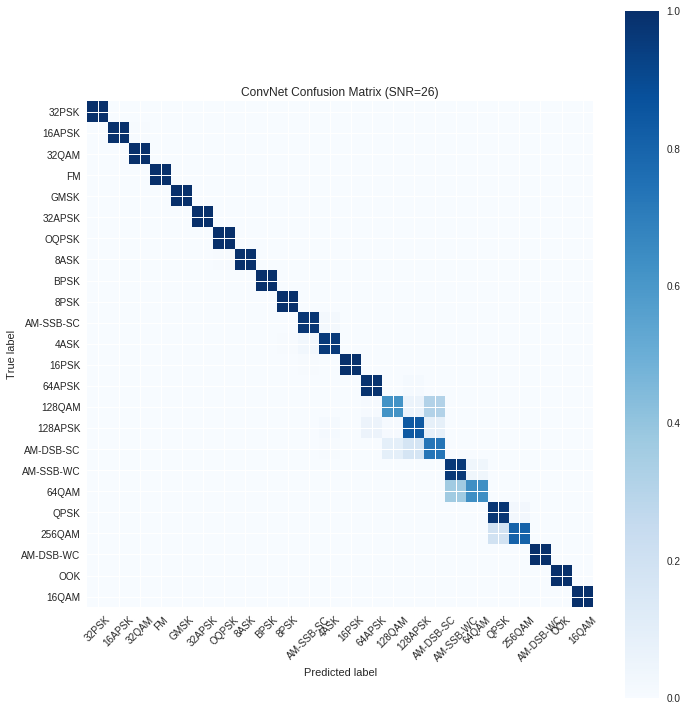

<Figure size 432x288 with 0 Axes>

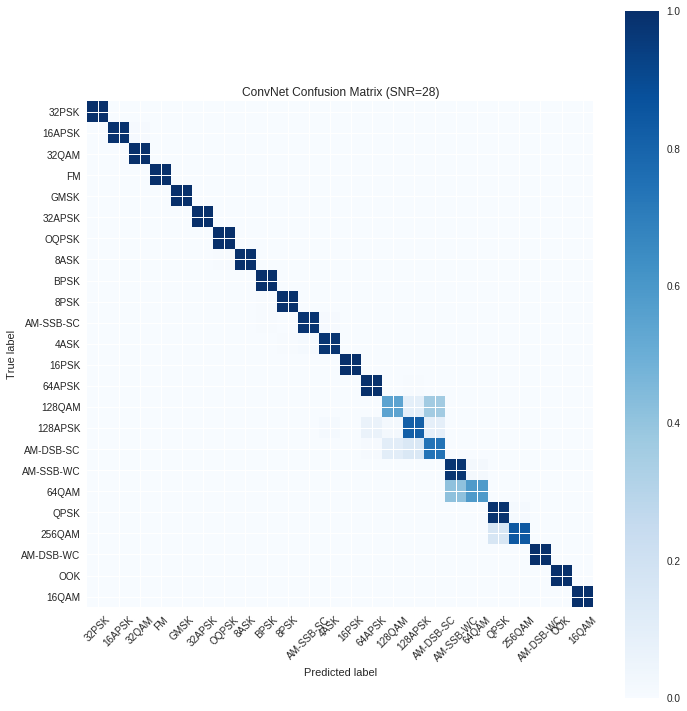

<Figure size 432x288 with 0 Axes>

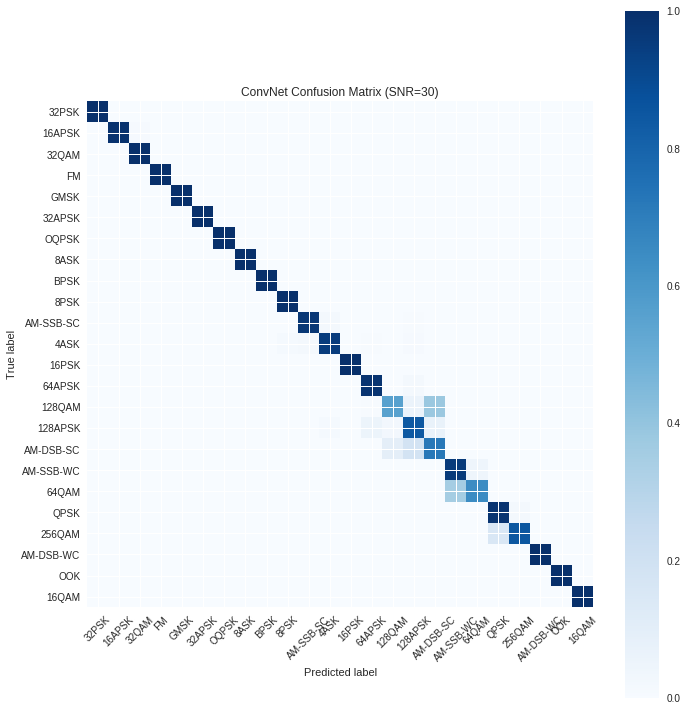

In [0]:
acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

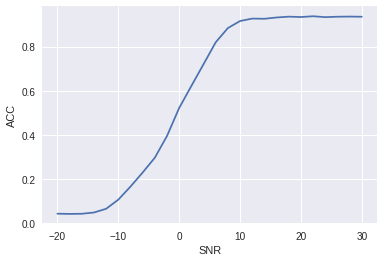

In [0]:
plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.show()

In [0]:
'''
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
'''

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
'''
!mkdir -p drive
!google-drive-ocamlfuse drive
'''